#Importações

In [1]:
!pip install gdown
!pip install torch
!pip install sklearn
!pip install tslearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tslearn.metrics import SoftDTWLossPyTorch
from torch.nn import MultiheadAttention
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# Pré-processamento

bitcoin: https://drive.google.com/file/d/1an5nASu-pNeWXi02Bm4yRcrY_8gj0GF3/view?usp=drive_link

In [3]:
#baixando o dataset do bitcoin
!gdown https://drive.google.com/uc?id=1an5nASu-pNeWXi02Bm4yRcrY_8gj0GF3

Downloading...
From: https://drive.google.com/uc?id=1an5nASu-pNeWXi02Bm4yRcrY_8gj0GF3
To: /content/BTC-USD.csv
100% 221k/221k [00:00<00:00, 4.84MB/s]


In [4]:
#lendo o dataset da serie temporal
df_bit = pd.read_csv('BTC-USD.csv')

In [5]:
df_bit.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [6]:
#filtrando o range de datas selecionado
df_bit['Date'] = pd.to_datetime(df_bit['Date'])

df_bitcoin = df_bit[df_bit['Date'] >= '2019-01-01'].reset_index(drop=True)

df_bitcoin

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990
1,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836
2,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219
3,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467
4,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824
...,...,...,...,...,...,...,...
1141,2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125,44575.203125,22721659051
1142,2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375,43961.859375,19792547657
1143,2022-02-17,43937.070313,44132.972656,40249.371094,40538.011719,40538.011719,26246662813
1144,2022-02-18,40552.132813,40929.152344,39637.617188,40030.976563,40030.976563,23310007704


In [7]:
#mantendo apenas os dados de date e high do dataset
df_bitcoin.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [8]:
df_bitcoin.head()

,Date,High
0,2019-01-01,3850.913818
1,2019-01-02,3947.981201
2,2019-01-03,3935.685059
3,2019-01-04,3865.934570
4,2019-01-05,3904.903076


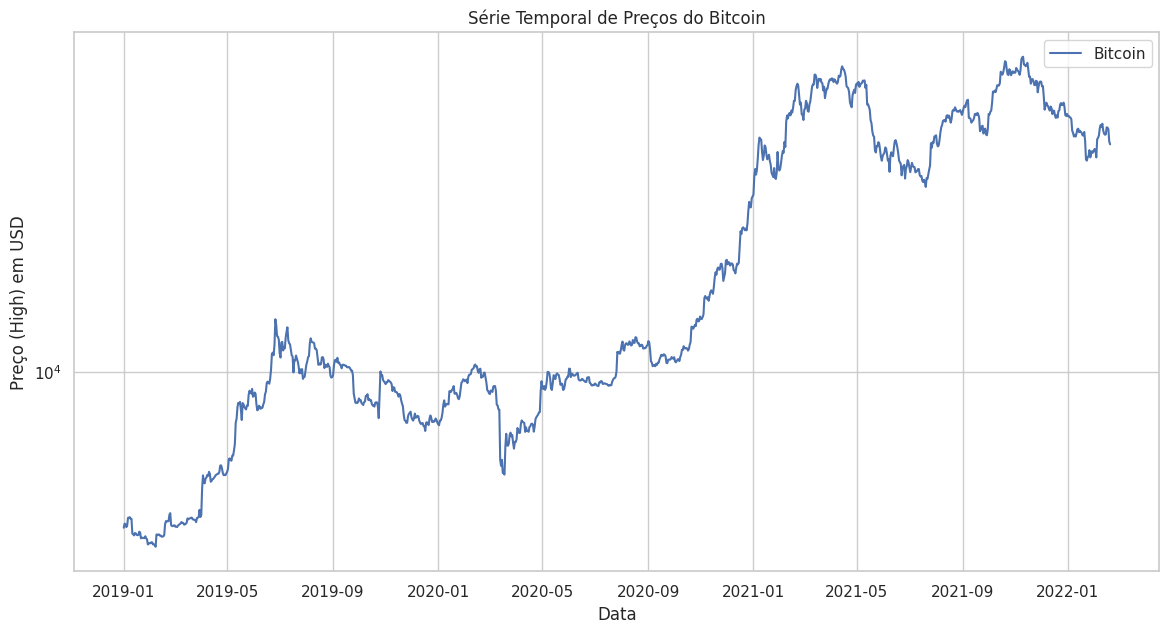

In [9]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_bitcoin, x='Date', y='High', label='Bitcoin')
plt.yscale('log')  # Escala logarítmica no eixo y pra conseguirmos enxergar melhor as variações
plt.title('Série Temporal de Preços do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Preço (High) em USD')
plt.legend()

# Exibe o gráfico
plt.show()


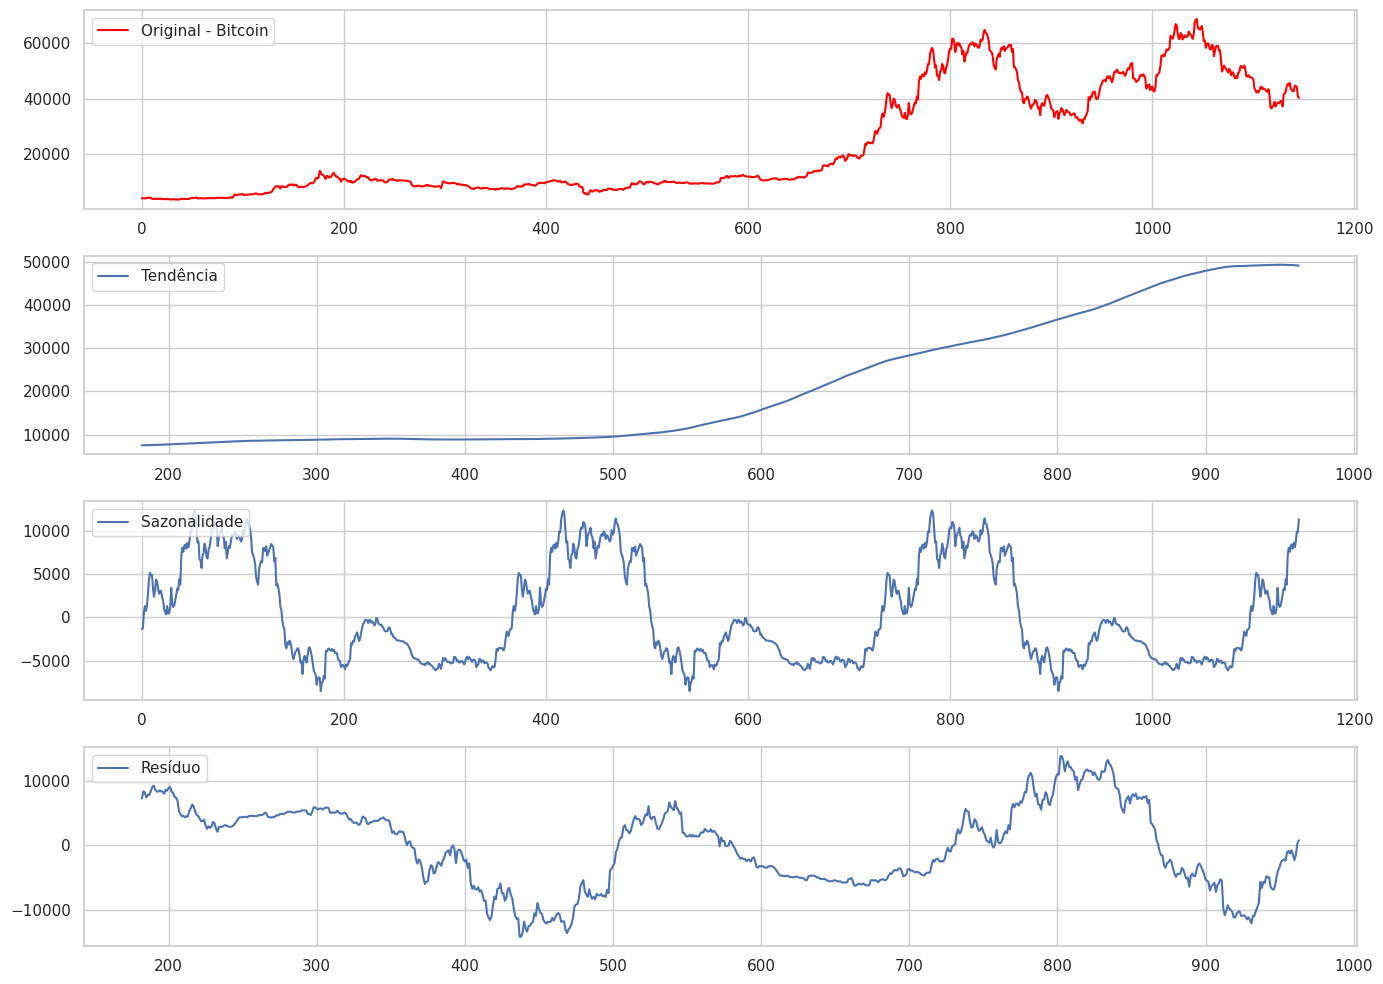

In [10]:
#plotando a serie, tendência, sazonalidade e residuo
series = df_bitcoin['High']

result = seasonal_decompose(series, model='additive', period=365)

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(series, color = 'red', label='Original - Bitcoin')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Tendência')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Resíduo')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
# Calculando a média e o desvio padrão
mean_bitcoin = df_bitcoin['High'].mean()
std_bitcoin = df_bitcoin['High'].std()

# z-noralizando manualmente
df_bitcoin['High_z'] = (df_bitcoin['High'] - mean_bitcoin) / std_bitcoin

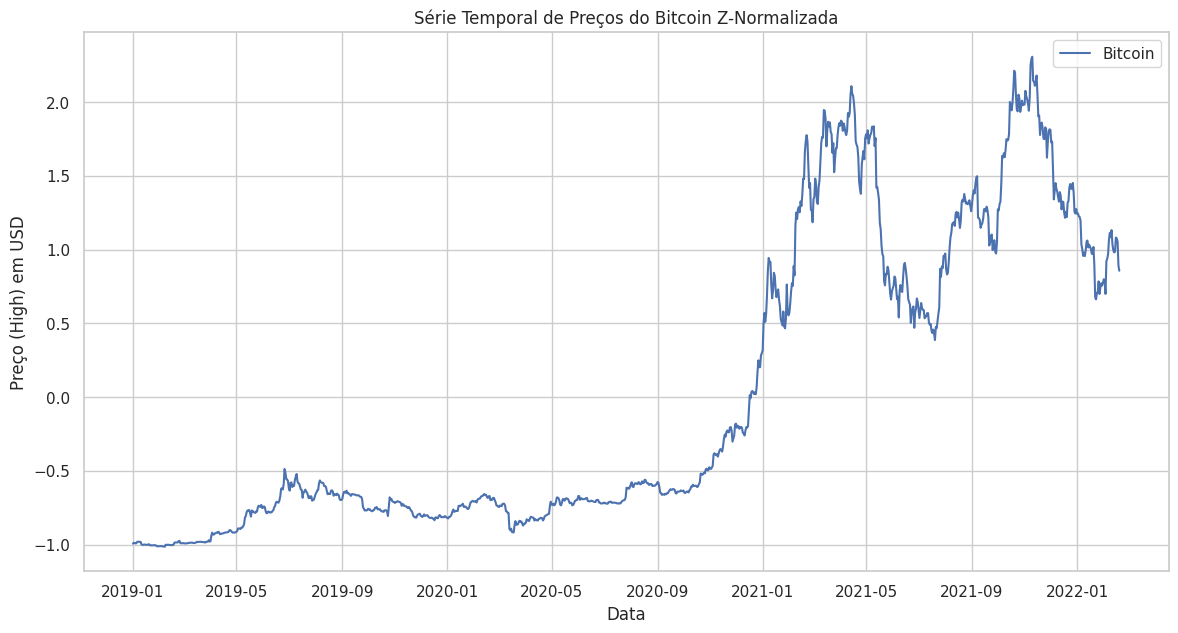

In [12]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_bitcoin, x='Date', y='High_z', label='Bitcoin')
plt.title('Série Temporal de Preços do Bitcoin Z-Normalizada')
plt.xlabel('Data')
plt.ylabel('Preço (High) em USD')
plt.legend()

# Exibe o gráfico
plt.show()

In [13]:
ts_bitcoin_norm = df_bitcoin['High_z']

# Baseline 1: Modelo LSTM para forecast

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout_prob=0.2):
        super(LSTMModel, self).__init__()

        # LSTM Layer with Dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)

        # Dropout after LSTM (can be adjusted)
        self.dropout = nn.Dropout(dropout_prob)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, pred_len=10):
        # LSTM processing
        out, _ = self.lstm(x)

        # Apply dropout
        out = self.dropout(out)

        # Apply Fully Connected Layer (predict sequence)
        out = out[:, -pred_len:, :]  # Select the last 'pred_len' time steps
        out = self.fc(out)

        return out

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout_prob=0.2):
        super(GRUModel, self).__init__()

        # GRU Layer com Dropout
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)

        # Dropout após GRU (opcional)
        self.dropout = nn.Dropout(dropout_prob)

        # Camada totalmente conectada (FC)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, pred_len=10):
        # Processamento GRU
        out, _ = self.gru(x)

        # Aplicar Dropout
        out = self.dropout(out)

        # Selecionar últimos 'pred_len' passos de tempo
        out = out[:, -pred_len:, :]
        out = self.fc(out)

        return out


In [ ]:
def prepare_data(normalized_data, seq_len, pred_len):
    total_len = seq_len + pred_len
    num_samples = len(normalized_data) - total_len + 1
    data = np.array([normalized_data[i:i + total_len] for i in range(num_samples)])

    X = data[:,:seq_len]
    y = data[:,seq_len:seq_len+pred_len]
    return X, y


In [ ]:
# Forecasting with LSTM or GRU using Soft-DTW Loss
def lstm_gru_forecast(data, seq_len=40, pred_len=10, percent_train=0.7, epochs=100, hidden_size=64, learning_rate=0.01, gamma=1.0, batch_size=16, MODEL_TYPE='LSTM'):
    # Prepare data
    X, y = prepare_data(data, seq_len, pred_len)

    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=percent_train, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Convertendo para pytorch
    def to_tensor(arr):
        return torch.FloatTensor(arr).unsqueeze(-1)

    X_train, y_train = to_tensor(X_train), to_tensor(y_train)
    X_val, y_val = to_tensor(X_val), to_tensor(y_val)
    X_test, y_test = to_tensor(X_test), to_tensor(y_test)

    # Model selection based on MODEL_TYPE
    if MODEL_TYPE == 'LSTM':
        MODEL = LSTMModel(input_size=1, hidden_size=hidden_size)
    elif MODEL_TYPE == 'GRU':
        MODEL = GRUModel(input_size=1, hidden_size=hidden_size)
    else:
        raise ValueError("MODEL_TYPE must be 'LSTM' or 'GRU'")

    # Loss, Optimizer, and Scheduler
    criterion = SoftDTWLossPyTorch(gamma=gamma, normalize=True)
    optimizer = torch.optim.Adam(MODEL.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        MODEL.train()
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0

        for i in range(0, X_train.size(0), batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            preds = MODEL(batch_x)  # preds shape: (batch_size, sequence_length, 1)

            # Ensure 3D shape for SoftDTWLoss
            loss = criterion(preds, batch_y).mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(MODEL.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()

        # Validation
        MODEL.eval()
        with torch.no_grad():
            val_preds = MODEL(X_val)  # val_preds shape: (batch_size, sequence_length, 1)
            val_loss = criterion(val_preds, y_val).mean().item()

        scheduler.step(val_loss)

        avg_epoch_loss = epoch_loss / (X_train.size(0) // batch_size)
        train_losses.append(avg_epoch_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss- Baseline")
    plt.show()

    return MODEL, X_test, y_test


Epoch 10/100, Train Loss: 0.4569, Val Loss: 0.3531
Epoch 20/100, Train Loss: 0.2978, Val Loss: 0.5359
Epoch 30/100, Train Loss: 0.2747, Val Loss: 0.3338
Epoch 40/100, Train Loss: 0.2508, Val Loss: 0.1910
Epoch 50/100, Train Loss: 0.2114, Val Loss: 0.1652
Epoch 60/100, Train Loss: 0.1793, Val Loss: 0.1755
Epoch 70/100, Train Loss: 0.1282, Val Loss: 0.0981
Epoch 80/100, Train Loss: 0.1038, Val Loss: 0.0515
Epoch 90/100, Train Loss: 0.0773, Val Loss: 0.0508
Epoch 100/100, Train Loss: 0.0696, Val Loss: 0.0433


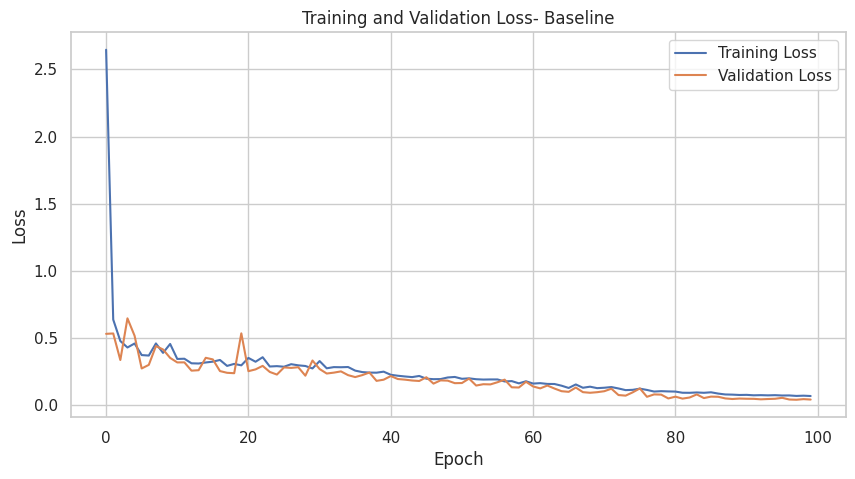

In [ ]:
model, X_test, y_test = lstm_gru_forecast(ts_bitcoin_norm.to_numpy(), gamma=0.01, MODEL_TYPE='LSTM')

In [ ]:
def evaluate_model(model, X_test, y_test):
    model.eval()

    # Get predictions for the test set
    with torch.no_grad():
        y_pred = model(X_test)

    y_pred = y_pred.squeeze(-1)  # Shape becomes (batch_size, pred_len)
    y_test = y_test.squeeze(-1)  # Shape becomes (batch_size, pred_len)

    # Calculate MSE and MAE
    mse = mean_squared_error(y_test.numpy(), y_pred.numpy())
    mae = mean_absolute_error(y_test.numpy(), y_pred.numpy())
    rmse = np.sqrt(mse)  # Calculate RMSE from MSE
    return mse, mae, rmse

In [ ]:
mse, mae, rmse = evaluate_model(model, X_test, y_test)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f"Root Mean Squared Error:{rmse:.4f}")

Mean Squared Error: 0.0048
Mean Absolute Error: 0.0466
Root Mean Squared Error:0.0692


# Baseline 2: Modelo GRU para forecast

Epoch 10/100, Train Loss: 0.3883, Val Loss: 0.3492
Epoch 20/100, Train Loss: 0.2850, Val Loss: 0.2342
Epoch 30/100, Train Loss: 0.2222, Val Loss: 0.2131
Epoch 40/100, Train Loss: 0.1684, Val Loss: 0.1887
Epoch 50/100, Train Loss: 0.1199, Val Loss: 0.0827
Epoch 60/100, Train Loss: 0.0884, Val Loss: 0.0537
Epoch 70/100, Train Loss: 0.0772, Val Loss: 0.0473
Epoch 80/100, Train Loss: 0.0759, Val Loss: 0.0501
Epoch 90/100, Train Loss: 0.0710, Val Loss: 0.0452
Epoch 100/100, Train Loss: 0.0714, Val Loss: 0.0444


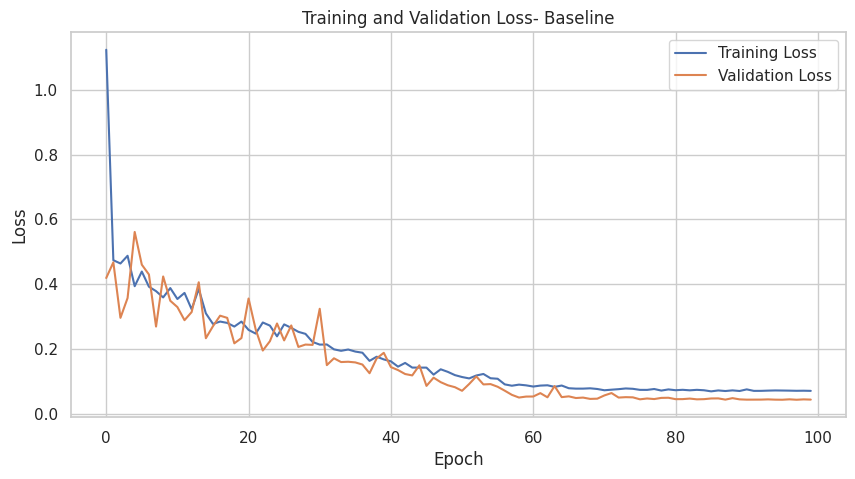

In [ ]:
model2, X_test2, y_test2 = lstm_gru_forecast(ts_bitcoin_norm.to_numpy(), gamma=0.01, MODEL_TYPE='GRU')

In [ ]:
mse2, mae2, rmse2 = evaluate_model(model2, X_test2, y_test2)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f"Root Mean Squared Error:{rmse:.4f}")

Mean Squared Error: 0.0073
Mean Absolute Error: 0.0590
Root Mean Squared Error:0.0852


# Código Autoformer Simplificado

In [14]:
ts_bitcoin_norm.shape

(1146,)

In [15]:
# 1. Series Decomposition
class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super(SeriesDecomposition, self).__init__()
        self.moving_avg = nn.AvgPool1d(kernel_size, stride=1, padding=kernel_size // 2)

    def forward(self, x):
        trend = self.moving_avg(x.unsqueeze(1)).squeeze(1)
        seasonal = x - trend
        return trend, seasonal

In [16]:
# 2. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pe = nn.Parameter(torch.zeros(1, seq_len, embed_dim))

    def forward(self, x):
        # Adiciona positional encoding ao tensor de entrada.
        return x + self.pe

In [17]:
# 3. Auto-Correlation

class AutoCorrelation(nn.Module):
    def __init__(self, seq_len, embed_dim, num_heads):
        super(AutoCorrelation, self).__init__()
        self.self_attention = MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

    def forward(self, x):
        x = x.transpose(0, 1)
        attn_output, _ = self.self_attention(x, x, x)
        return attn_output.transpose(0, 1)

In [18]:
# 4. Autoformer Model
class Autoformer(nn.Module):
    def __init__(self, seq_len, pred_len, kernel_size, embed_dim=128, num_heads=4, dropout_rate=0.2):
        super(Autoformer, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.embed_dim = embed_dim

        # Componentes
        self.decomposition = SeriesDecomposition(kernel_size)
        self.auto_correlation = AutoCorrelation(seq_len, embed_dim, num_heads)
        self.positional_encoding = PositionalEncoding(seq_len, embed_dim)

        # Camadas de projeção dimensional
        self.input_projection = nn.Linear(seq_len, embed_dim)
        self.output_projection = nn.Linear(embed_dim, pred_len)

        # Encoder e Decoder
        self.encoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)  # Adiciona a dimensão caso não exista

        batch_size, seq_len, feature_dim = x.shape

        # Decomposição da série
        trend, seasonal = self.decomposition(x.squeeze(-1))  # Remove feature_dim temporariamente

        seasonal_proj = self.input_projection(seasonal)
        seasonal_proj = seasonal_proj.unsqueeze(1).repeat(1, self.seq_len, 1)
        seasonal_corr = self.auto_correlation(self.positional_encoding(seasonal_proj))

        trend_proj = self.input_projection(trend)
        enc_trend = self.encoder(trend_proj)
        enc_seasonal = self.encoder(seasonal_corr.mean(dim=1))

        dec_trend = self.decoder(enc_trend)
        dec_seasonal = self.decoder(enc_seasonal)

        trend_pred = self.output_projection(dec_trend)
        seasonal_pred = self.output_projection(dec_seasonal)

        return (trend_pred + seasonal_pred).unsqueeze(-1)

In [19]:
def train_autoformer(data,
                     seq_len = 40,
                     pred_len = 10,
                     kernel_size = 5,
                     embed_dim = 128,
                     num_heads = 4,
                     dropout_rate = 0.2,
                     learning_rate = 0.001,
                     weight_decay = 1e-4,
                     epochs = 100,
                     batch_size = 16,
                     percent_train = 0.8,
                     loss_fn = nn.MSELoss()):

    #divide as sequencias base e as sequencias a serem preditas
    X = data[:, :seq_len]
    y = data[:, seq_len:seq_len+pred_len]

    #divide em treino, validação e teste
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=int(percent_train * len(data)), random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    #tratamento para adicionar uma dimensão
    def to_tensor(arr):
        return torch.FloatTensor(arr).unsqueeze(-1)

    X_train, y_train = to_tensor(X_train), to_tensor(y_train)
    X_val, y_val = to_tensor(X_val), to_tensor(y_val)
    X_test, y_test = to_tensor(X_test), to_tensor(y_test)

    model = Autoformer(seq_len=seq_len, pred_len=pred_len, kernel_size=kernel_size,
                       embed_dim=embed_dim, num_heads=num_heads, dropout_rate=dropout_rate)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0

        for i in range(0, X_train.size(0), batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]
            preds = model(batch_x)
            loss = loss_fn(preds, batch_y).mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = loss_fn(val_preds, y_val).mean().item()

        scheduler.step(val_loss)

        avg_epoch_loss = epoch_loss / (X_train.size(0) // batch_size)
        train_losses.append(avg_epoch_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss - Autoformer ")
    plt.show()

    return model, X_test, y_test

In [20]:
# Separa os dados da serie temporal em varias amostras de tamanho menor
def prepare_data(normalized_data, seq_len, pred_len):
    total_len = seq_len + pred_len
    num_samples = len(normalized_data) - total_len + 1

    data = np.array([normalized_data[i:i + total_len] for i in range(num_samples)])

    return data

In [21]:
def plot_comparison(base_values, true_values, predictions):
    # Transformando em array numpy e garantindo que sejam 1D
    if hasattr(base_values, 'detach'):
        base_values = base_values.detach().cpu().numpy()
    if hasattr(true_values, 'detach'):
        true_values = true_values.detach().cpu().numpy()
    if hasattr(predictions, 'detach'):
        predictions = predictions.detach().cpu().numpy()

    # Achatar para 1D, caso tenha dimensões extras
    base_values = np.ravel(base_values)
    true_values = np.ravel(true_values)
    predictions = np.ravel(predictions)

    # Definindo os eixos de tempo
    time_base = np.arange(len(base_values))
    time_forecast = np.arange(len(base_values), len(base_values) + len(true_values))

    plt.figure(figsize=(12, 6))
    plt.plot(time_base, base_values, label="Base", color="green", linewidth=2)

    plt.plot(
        np.concatenate(([len(base_values) - 1], time_forecast)),
        np.concatenate(([base_values[-1]], true_values)),
        label="Real", color="blue", linewidth=2
    )

    plt.plot(
        np.concatenate(([len(base_values) - 1], time_forecast)),
        np.concatenate(([base_values[-1]], predictions)),
        label="Predito", color="orange", linestyle="--", linewidth=2
    )

    plt.title("Comparação: Reais vs. Preditos", fontsize=16)
    plt.xlabel("Tempo", fontsize=14)
    plt.ylabel("Valor", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.4)

    plt.tight_layout()
    plt.show()

In [22]:
seq_len = 40
pred_len = 10

data = prepare_data(ts_bitcoin_norm, seq_len, pred_len)

##MSE Loss

Epoch 10/100, Train Loss: 0.0284, Val Loss: 0.0225
Epoch 20/100, Train Loss: 0.0239, Val Loss: 0.0155
Epoch 30/100, Train Loss: 0.0210, Val Loss: 0.0114
Epoch 40/100, Train Loss: 0.0195, Val Loss: 0.0116
Epoch 50/100, Train Loss: 0.0188, Val Loss: 0.0114
Epoch 60/100, Train Loss: 0.0178, Val Loss: 0.0115
Epoch 70/100, Train Loss: 0.0187, Val Loss: 0.0111
Epoch 80/100, Train Loss: 0.0179, Val Loss: 0.0112
Epoch 90/100, Train Loss: 0.0179, Val Loss: 0.0111
Epoch 100/100, Train Loss: 0.0183, Val Loss: 0.0111


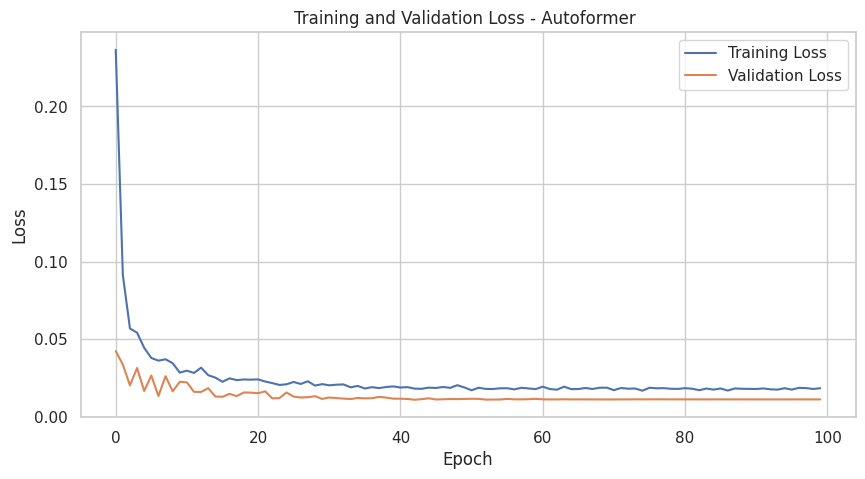

In [23]:
#treinando o modelo com loss MSE
model, X_test, y_test = train_autoformer(data, seq_len, pred_len, loss_fn = nn.MSELoss())

#predições do teste
model.eval()
with torch.no_grad():
    test_preds = model(X_test).numpy()

In [24]:
for i in range(len(y_test)):
  plot_comparison(X_test[i], y_test[i], test_preds[i])

Output hidden; open in https://colab.research.google.com to view.

In [25]:
mae = mean_absolute_error(y_test.squeeze(-1), test_preds.squeeze(-1))
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test.squeeze(-1), test_preds.squeeze(-1))
print(f'Mean Squared Error (MSE): {mse}')

rmse = root_mean_squared_error(y_test.squeeze(-1), test_preds.squeeze(-1))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 0.07671372592449188
Mean Squared Error (MSE): 0.014644687995314598
Root Mean Squared Error (RMSE): 0.11917195469141006


##Soft-DTW Loss

Epoch 10/100, Train Loss: 0.2165, Val Loss: 0.0635
Epoch 20/100, Train Loss: 0.1312, Val Loss: 0.0436
Epoch 30/100, Train Loss: 0.0695, Val Loss: -0.0141
Epoch 40/100, Train Loss: 0.0390, Val Loss: -0.0313
Epoch 50/100, Train Loss: 0.0438, Val Loss: -0.0279
Epoch 60/100, Train Loss: 0.0333, Val Loss: -0.0258
Epoch 70/100, Train Loss: 0.0182, Val Loss: -0.0345
Epoch 80/100, Train Loss: 0.0209, Val Loss: -0.0361
Epoch 90/100, Train Loss: 0.0194, Val Loss: -0.0385
Epoch 100/100, Train Loss: 0.0171, Val Loss: -0.0388


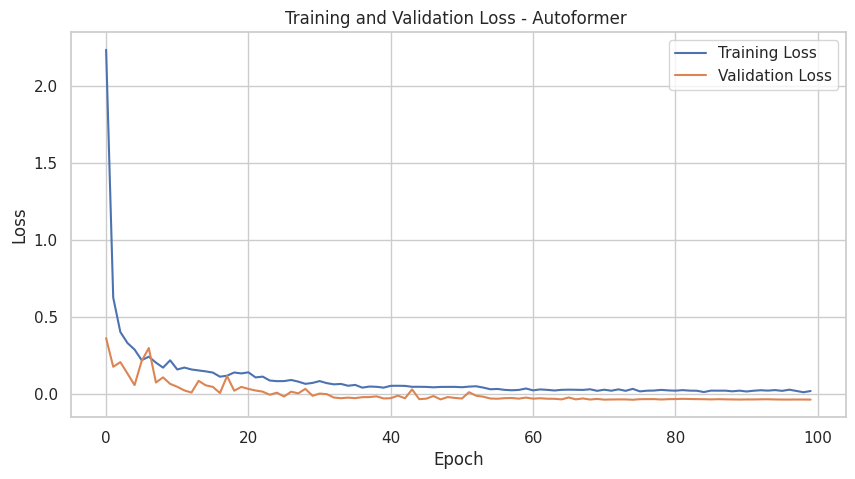

In [26]:
#treinando o modelo com loss Soft-DTW
model, X_test, y_test = train_autoformer(data, seq_len, pred_len, loss_fn = SoftDTWLossPyTorch(gamma=0.01))

#predições do teste
model.eval()
with torch.no_grad():
    test_preds = model(X_test).numpy()

In [27]:
mae = mean_absolute_error(y_test.squeeze(-1), test_preds.squeeze(-1))
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test.squeeze(-1), test_preds.squeeze(-1))
print(f'Mean Squared Error (MSE): {mse}')

rmse = root_mean_squared_error(y_test.squeeze(-1), test_preds.squeeze(-1))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 0.07376691699028015
Mean Squared Error (MSE): 0.014405451714992523
Root Mean Squared Error (RMSE): 0.11715497076511383
